#### Quantitative Analysis

1. This notebook covers the quantivative analysis.

2. Chosen metrics - mAP@0.5, mAP@0.5:0.95, Precision, Recall, IoU (More details in README)

3. Short analysis given after results in the notebook and detialed analysis is present in the `docs/model_analysis.md` file.

In [1]:
import pandas as pd
import json
from pathlib import Path
from pycocotools.coco import COCO
from ultralytics import YOLO

In [2]:
# Adjust paths after running the training script
gt_path = Path("../data/coco_data/bdd100k_val_coco.json")
meta_path = Path("../data/parsed_data/val_data.parquet")
training_metrics_path = Path("../runs/train/yolo11s_NoFreeze/results.csv")
model_path = Path("../runs/train/yolo11s_NoFreeze/weights/best.pt")
config_path = Path("../data/yolo_data/dataset.yaml")


In [3]:
detection_classes = [
        "person",
        "rider",
        "car",
        "bus",
        "truck",
        "bike",
        "motor",
        "traffic light",
        "traffic sign",
        "train",
    ]

In [4]:
model = YOLO(model_path)
metrics = model.val(data=config_path, save_json=True, plots=False, save=False)

Ultralytics 8.3.162 🚀 Python-3.12.3 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLO11s summary (fused): 100 layers, 9,416,670 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 1.2±0.6 ms, read: 77.1±34.5 MB/s, size: 57.3 KB)


val: Scanning /home/anish/data/projects/autonomous-vision-bdd100k/data/yolo_data/labels/val.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 625/625 [01:30<00:00,  6.91it/s]


                   all      10000     185526      0.674      0.436      0.478      0.269
                person       3220      13262      0.678      0.513      0.574      0.281
                 rider        515        649      0.566      0.361      0.386      0.183
                   car       9879     102506      0.752       0.71      0.763      0.476
                   bus       1242       1597      0.606       0.52      0.563      0.432
                 truck       2689       4245      0.627      0.546      0.595      0.427
                  bike        578       1007       0.54      0.362      0.381      0.187
                 motor        334        452      0.597      0.279      0.342       0.17
         traffic light       5653      26885      0.687      0.512      0.565      0.212
          traffic sign       8221      34908       0.69      0.553      0.606      0.319
                 train         14         15          1          0          0          0
Speed: 0.1ms preproce

From the above metrics, it is clear that modek handles common objects like cars, trucks, and buses quite well. This makes sense given that how often they appear in both the training and validation sets. On the other hand, the model struggles with less frequent classes like trains, motorcycles, riders, and bikes. Their lower performance is due to the less samples the model had to during training.

Now, lets explore more with respect to meta data and check how model has performed.

In [8]:
coco_gt = COCO(gt_path)
val_df = pd.read_parquet(meta_path)
img_dir = Path("../data/yolo_data/images/val")  

with open("outputs/detect/val2/predictions.json", "r") as f:
    preds = json.load(f)


loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


In [9]:
preds_df = pd.DataFrame(preds)
print("Predictions sample:")
print(preds_df.head())

Predictions sample:
            image_id  category_id                                bbox    score
0  fe1f55fa-19ba3600            5  [446.189, 335.78, 80.977, 107.261]  0.71283
1  fe1f55fa-19ba3600            9  [607.539, 310.852, 23.309, 44.367]  0.66342
2  fe1f55fa-19ba3600            9     [112.4, 332.247, 24.76, 17.305]  0.55370
3  fe1f55fa-19ba3600            3  [456.777, 405.957, 45.066, 36.857]  0.46833
4  fe1f55fa-19ba3600            3  [371.242, 408.339, 23.344, 22.487]  0.42904


In [35]:
MODEL_PATH = "../models/yolo11s_bdd.pt"
VAL_IMAGES_DIR = Path("../data/yolo_data/images/val")
VAL_LABELS_DIR = Path("../data/yolo_data/labels/val")
IMG_SIZE = (1280, 720)  # Original image size
N_IMAGES = 200

In [49]:
def compute_iou(box_a, box_b):
    # Sort coordinates to ensure proper ordering
    ax1, ax2 = sorted([float(box_a[0]), float(box_a[2])])
    ay1, ay2 = sorted([float(box_a[1]), float(box_a[3])])
    bx1, bx2 = sorted([float(box_b[0]), float(box_b[2])])
    by1, by2 = sorted([float(box_b[1]), float(box_b[3])])

    # Intersection rectangle
    x_a = max(ax1, bx1)
    y_a = max(ay1, by1)
    x_b = min(ax2, bx2)
    y_b = min(ay2, by2)

    inter_area = max(0, x_b - x_a) * max(0, y_b - y_a)
    box_a_area = max(0, ax2 - ax1) * max(0, ay2 - ay1)
    box_b_area = max(0, bx2 - bx1) * max(0, by2 - by1)

    union_area = box_a_area + box_b_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

In [50]:
image_paths = sorted(Path(VAL_IMAGES_DIR).glob("*.jpg"))[:N_IMAGES]
print(f"Found {len(image_paths)} images to process")

Found 200 images to process


In [ ]:
from collections import defaultdict
import cv2
iou_scores = []
classwise_iou = defaultdict(list)

for img_path in image_paths:
    img = cv2.imread(str(img_path))
    img = cv2.resize(img, IMG_SIZE)


    label_file = Path(VAL_LABELS_DIR) / (img_path.stem + ".txt")
    gt_boxes, gt_classes = [], []
    if label_file.exists():
        with open(label_file, "r") as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                x1 = int((x - bw / 2) * IMG_SIZE[0])
                y1 = int((y - bh / 2) * IMG_SIZE[1])
                x2 = int((x + bw / 2) * IMG_SIZE[0])
                y2 = int((y + bh / 2) * IMG_SIZE[1])
                gt_boxes.append([x1, y1, x2, y2])
                gt_classes.append(int(cls))


    results = model.predict(str(img_path), imgsz=IMG_SIZE[0],
                            conf=0.25, iou=0.45, verbose=False)

    for r in results:
        pred_boxes = r.boxes.xyxy.cpu().numpy()
        pred_classes = r.boxes.cls.cpu().numpy()
        pred_scores = r.boxes.conf.cpu().numpy()

        matched_gt = set()
        for i, pred_box in enumerate(pred_boxes):
            pred_cls = int(pred_classes[i])
            best_iou = 0
            best_gt = -1
            for j, gt_box in enumerate(gt_boxes):
                if j in matched_gt:
                    continue
                iou = compute_iou(pred_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt = j
            if best_iou > 0.5:
                matched_gt.add(best_gt)
                iou_scores.append(best_iou)
                class_name = class_names[pred_cls]
                classwise_iou[class_name].append(best_iou)



/tmp/ipykernel_534245/3177864944.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(classwise_iou))  # Distinct colors


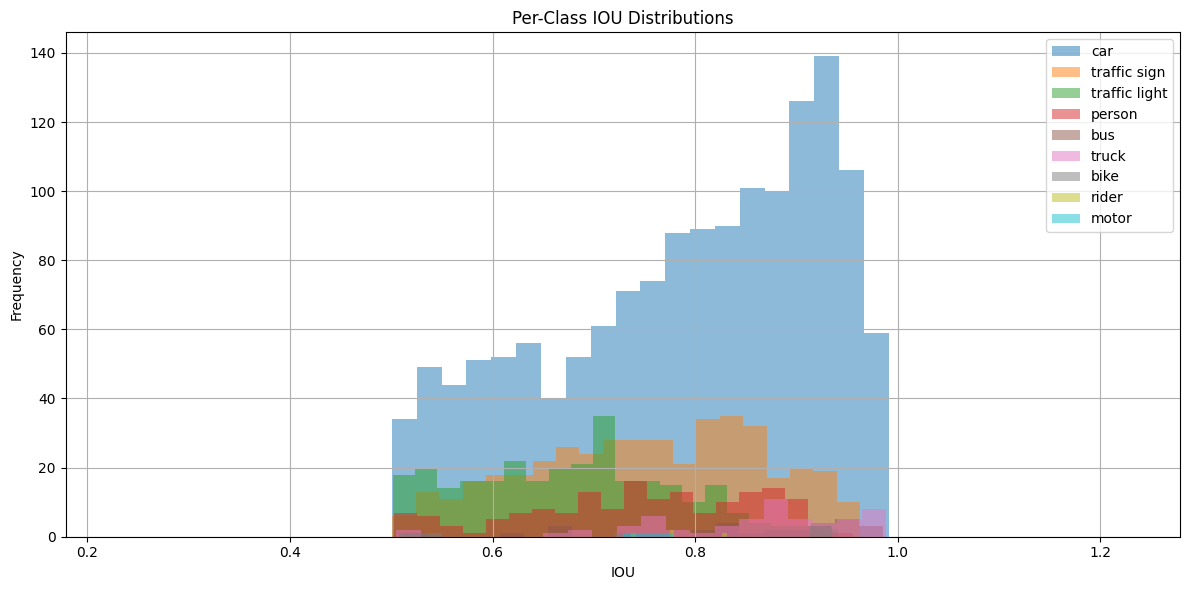

In [54]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
colors = plt.cm.get_cmap('tab10', len(classwise_iou))  # Distinct colors

for idx, (cls, ious) in enumerate(classwise_iou.items()):
    plt.hist(ious, bins=20, alpha=0.5, label=cls, color=colors(idx))

plt.title("Per-Class IOU Distributions")
plt.xlabel("IOU")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Car detections dominate the histogram, this matches earlier mAP results, where cars had the highest AP. Traffic signs and traffic lights have good IOUs clustered around 0.7–0.85, but with a wider spread than cars. This aligns with the earlier small-object analysis. Persons, buses, trucks sit in the mid-range (0.6–0.85), showing more variability in localization. Likely due to occlusion (as found in EDA). 

The overall pattern matches the dataset bias.

#### Model Evaluation – Next Steps (if more time was available)

##### 1. Prepare Data
- Load **BDD100K validation annotations** (COCO format).
- Load **YOLO predictions** 
- Align IDs:
  - Map YOLO `image_id` → COCO integer IDs.
  - Convert `category_id` from 0-based → 1-based.

##### 2. Evaluate Performance
- Use **COCO API** to calculate:
  - `mAP@[.5:.95]`
  - `mAP@0.5`
  - Class-wise precision & recall.

##### 3. Analyze by Real-World Conditions
- Scene type (city street, highway, residential, tunnel).
- Weather (clear, overcast, rainy, snowy).
- Time of day (daytime, night, dawn/dusk).